Timeseries plots of all tickets over time, broken down by inquiry type

In [ ]:
# This is an example snippet!
# To create your own, add a new snippet block to the
# snippets.json file in your jupyter nbextensions directory:
# /nbextensions/snippets/snippets.json
import this

In [149]:
import pandas as pd
import sqlalchemy
import os
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [43]:
%matplotlib inline

In [44]:
matplotlib.rcParams.update({'font.size': 15})

## Connect to dw

In [5]:
attune_dw_host = os.getenv('ATTUNE_DW_HOST')
attune_dw_user = os.getenv('ATTUNE_DW_USER')
attune_dw_db = os.getenv('ATTUNE_DW_DB', 'attune_dw')


connection_args = {'user': attune_dw_user, 'host': attune_dw_host, 'db': attune_dw_db}
attune_dw_engine = sqlalchemy.create_engine('postgresql://{user}@{host}/{db}'.format(**connection_args))

## Tickets

In [26]:
query = 'select count(distinct(ticket_id)) from zendesk_tickets'
pd.read_sql_query(query, attune_dw_engine)

count
0  144640

Get timeseries of tickets created by date and inquiry type

In [28]:
query = 'select date(created_at)::date as date, inquiry_type, count(*) \
from zendesk_tickets \
group by 1,2 \
order by 1 asc, 3 desc;'

date_itype_df = pd.read_sql_query(query, attune_dw_engine)

In [40]:
date_itype_df.head(15)

date                     inquiry_type  count
0   2017-09-21               renewal_indication      1
1   2017-10-30               agent_cancellation      1
2   2017-12-14                     endorsements      1
3   2017-12-21                      eligibility      2
4   2017-12-27                      eligibility      1
5   2018-01-03                      eligibility      1
6   2018-01-04                     endorsements      1
7   2018-01-05                     endorsements      2
8   2018-01-08  endorsement_non_premium_bearing      1
9   2018-01-08                     endorsements      1
10  2018-01-08                         renewals      1
11  2018-01-11                      eligibility      1
12  2018-01-15                     endorsements      1
13  2018-01-15                    quote_changes      1
14  2018-01-17                      eligibility      1

In [53]:
date_itype_df.groupby('date')['count'].sum().\
plot(figsize=(15,6),
     grid=True,
     title='Total Num Tickets Over Time',)

Separate weekends, agg by week, month

In [55]:
date_itype_df.groupby('date')['count'].sum().head()

date
2017-09-21    1
2017-10-30    1
2017-12-14    1
2017-12-21    2
2017-12-27    1
Name: count, dtype: int64

In [56]:
date_itype_df.head()

date        inquiry_type  count
0  2017-09-21  renewal_indication      1
1  2017-10-30  agent_cancellation      1
2  2017-12-14        endorsements      1
3  2017-12-21         eligibility      2
4  2017-12-27         eligibility      1

Remove weekends and holidays

In [94]:
import holidays

In [103]:
us_holidays = holidays.UnitedStates()

def to_day_type(date, us_holidays):
    if date.weekday()>=5:
        return 'weekend'
    elif date in us_holidays:
        return 'holiday'
    else:
        return 'weekday'

In [105]:
date_itype_df['day_type'] = date_itype_df.date.map(lambda x: to_day_type(x, us_holidays))

date_itype_df.day_type.value_counts()

Weekday raw and average

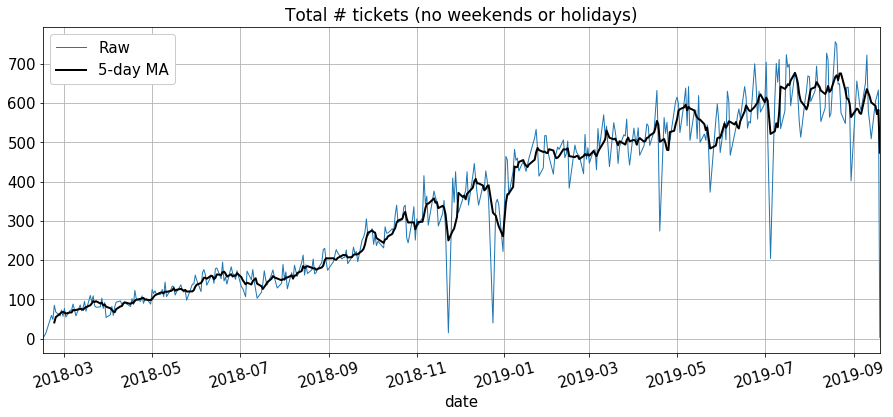

In [158]:
fig,ax = plt.subplots(figsize=(15,6))

ts = date_itype_df[date_itype_df.day_type=='weekday'].groupby('date')['count'].sum()[20:]
ts.plot(figsize=(15,6),
        grid=True,
        label='Raw',
        lw=1,
        ax=ax)


# reform timestamps
x = ts.index.values
y = ts.values

win = 5
ymean = pd.Series(y).rolling(win).mean()

ax.plot(x,ymean,'k',
        label="{}-day MA".format(win), lw=2)

# ax.set_xlabel('Day, Hour',fontsize=15)
# ax.set_ylabel('Flow Percentage',fontsize=15)
ax.set_title("Total # tickets (no weekends or holidays)", fontsize=17)
ax.tick_params(labelsize=15)
ax.xaxis.set_tick_params(rotation=15)

# Set x-axis major ticks to weekly interval, on Mondays
# ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MONDAY))
# Format x-tick labels as 3-letter month name and day number
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'));


# ax.vlines([x[23].date(),x[47].date()],0,1,linestyles='--',colors='k',linewidth=2)
# ax.hlines(0.3,x[0],x[-1],linestyles='--',colors='r',linewidth=2)
# ax.grid()

ax.legend(fontsize=15,framealpha=1)

In [ ]:
query = 'select date(created_at)::date as date, inquiry_type, count(*) \
from zendesk_tickets \
group by 1,2 \
order by 1 asc, 3 desc;'

date_itype_df = pd.read_sql_query(query, attune_dw_engine)

## Inquiry Type

In [124]:
date_itype_df.groupby('inquiry_type').sum().sort_values('count',ascending=False)

count
inquiry_type                          
quote_changes                    21863
workers_compensation             20502
billing_inquiries                18528
endorsements                     13283
eligibility                      12495
cancellations                    11513
miscellaneous_na                  7447
renewals                          6252
document_requested                5867
technical_support                 5060
about_attune                      5033
underwriting_audit                4948
policy_issuance_                  4216
voicemails                        3061
loss_runs                         1037
coverage_inquiries_                353
claim_inquiries                    337
binding_moratorium                 234
general_inquiry                    220
wc                                  63
collections                         33
intuit_support                      11
bind_requests                        8
document_requests                    4
renewal_indication                   1
agent_cancellation                   1
endorsement_non_premium_bearing      1

In [113]:
date_itype_df[date_itype_df.day_type=='weekday'].head()

date        inquiry_type  count day_type
0  2017-09-21  renewal_indication      1  weekday
1  2017-10-30  agent_cancellation      1  weekday
2  2017-12-14        endorsements      1  weekday
3  2017-12-21         eligibility      2  weekday
4  2017-12-27         eligibility      1  weekday

In [159]:
fig,ax = plt.subplots(figsize=(15,6))

sns.lineplot(x="date", y="count",
             hue="inquiry_type",
             data=date_itype_df[date_itype_df.day_type=='weekday'],
             ax=ax)

## Ticket JSON data

In [17]:
query = 'select * from zendesk_tickets_json limit 1'

sample_ticket_json = pd.read_sql_query(query, attune_dw_engine)['full_json'][0]

In [19]:
import json

In [23]:
# json.loads(sample_ticket_json)

## Users

In [9]:
query = 'select count(*) from zendesk_users'

pd.read_sql_query(query, attune_dw_engine)